In [ ]:
import pandas as pd
df = pd.read_csv('saudi_arabian_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:01:19.630000,VER,1,0 days 00:01:35.505000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:29.707000,...,True,Red Bull Racing,0 days 00:59:43.836000,2024-03-09 17:03:59.056,1,1.0,False,NaN,False,False
1,0 days 01:02:53.835000,VER,1,0 days 00:01:34.205000,2.0,1.0,NaN,NaN,0 days 00:00:34.720000,0 days 00:00:29.628000,...,True,Red Bull Racing,0 days 01:01:19.630000,2024-03-09 17:05:34.850,1,1.0,False,NaN,False,True
2,0 days 01:04:27.878000,VER,1,0 days 00:01:34.043000,3.0,1.0,NaN,NaN,0 days 00:00:34.530000,0 days 00:00:29.621000,...,True,Red Bull Racing,0 days 01:02:53.835000,2024-03-09 17:07:09.055,1,1.0,False,NaN,False,True
3,0 days 01:06:01.632000,VER,1,0 days 00:01:33.754000,4.0,1.0,NaN,NaN,0 days 00:00:34.416000,0 days 00:00:29.541000,...,True,Red Bull Racing,0 days 01:04:27.878000,2024-03-09 17:08:43.098,1,1.0,False,NaN,False,True
4,0 days 01:07:35.587000,VER,1,0 days 00:01:33.955000,5.0,1.0,NaN,NaN,0 days 00:00:34.457000,0 days 00:00:29.590000,...,True,Red Bull Racing,0 days 01:06:01.632000,2024-03-09 17:10:16.852,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,0 days 02:14:48.789000,PIA,81,0 days 00:01:32.557000,46.0,2.0,NaN,NaN,0 days 00:00:34.112000,0 days 00:00:29.071000,...,False,McLaren,0 days 02:13:16.232000,2024-03-09 18:17:31.452,1,4.0,False,NaN,False,True
897,0 days 02:16:21.363000,PIA,81,0 days 00:01:32.574000,47.0,2.0,NaN,NaN,0 days 00:00:34.006000,0 days 00:00:29.145000,...,False,McLaren,0 days 02:14:48.789000,2024-03-09 18:19:04.009,1,4.0,False,NaN,False,True
898,0 days 02:17:54.020000,PIA,81,0 days 00:01:32.657000,48.0,2.0,NaN,NaN,0 days 00:00:34.010000,0 days 00:00:29.151000,...,False,McLaren,0 days 02:16:21.363000,2024-03-09 18:20:36.583,1,4.0,False,NaN,False,True
899,0 days 02:19:26.608000,PIA,81,0 days 00:01:32.588000,49.0,2.0,NaN,NaN,0 days 00:00:34.052000,0 days 00:00:29.094000,...,False,McLaren,0 days 02:17:54.020000,2024-03-09 18:22:09.240,1,4.0,False,NaN,False,True


In [ ]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [ ]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 50
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [ ]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              1               8.0          25.000000   
1    ALO              1               8.0          25.000000   
2    BEA              1               8.0          25.000000   
3    BOT              2               8.0          16.333333   
4    GAS              0               0.0           1.000000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.000000              0.14         0.860000  
1          0.000000              0.14         0.860000  
2          0.140000              0.00         0.860000  
3          0.428571              0.00         0.571429  
4          0.000000              1.00         0.000000  


In [ ]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,7.0,0 days 01:11:39.002000,NaN,MEDIUM,7.0,1.0
1,ALB,8.0,NaN,0 days 01:12:00.635000,HARD,1.0,2.0
2,ALO,7.0,0 days 01:11:22.311000,NaN,MEDIUM,8.0,1.0
3,ALO,8.0,NaN,0 days 01:11:44.551000,HARD,2.0,2.0
4,BEA,7.0,0 days 01:11:37.184000,NaN,SOFT,7.0,1.0
5,BEA,8.0,NaN,0 days 01:11:59.637000,HARD,1.0,2.0
6,BOT,7.0,0 days 01:11:45.899000,NaN,SOFT,7.0,1.0
7,BOT,8.0,NaN,0 days 01:12:08.581000,HARD,1.0,2.0
8,BOT,35.0,0 days 01:58:44.198000,NaN,HARD,28.0,2.0
9,BOT,36.0,NaN,0 days 01:59:07.460000,SOFT,1.0,3.0


In [ ]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,8.0,25.000000,0.000000,0.140000,0.860000
1,ALO,1,8.0,25.000000,0.000000,0.140000,0.860000
2,BEA,1,8.0,25.000000,0.140000,0.000000,0.860000
3,BOT,2,8.0,16.333333,0.428571,0.000000,0.571429
4,GAS,0,0.0,1.000000,0.000000,1.000000,0.000000
5,HAM,1,37.0,25.000000,0.280000,0.720000,0.000000
6,HUL,1,34.0,25.000000,0.000000,0.660000,0.340000
7,LEC,1,8.0,25.000000,0.000000,0.140000,0.860000
8,MAG,1,8.0,25.000000,0.000000,0.140000,0.860000
9,NOR,1,38.0,25.000000,0.260000,0.740000,0.000000


In [ ]:
df = df[df['IsAccurate']]


In [ ]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,816


In [ ]:
df['Driver'].value_counts()


,count
Driver,
VER,46
PER,46
ALO,46
LEC,46
MAG,46
ALB,46
BEA,46
RUS,46
PIA,46


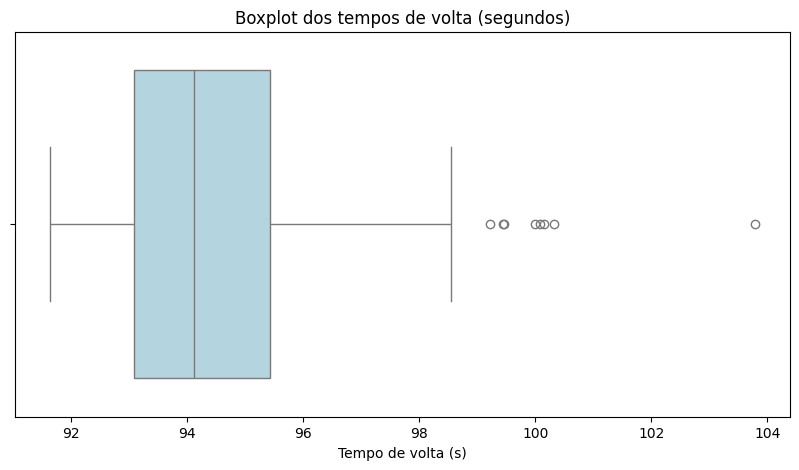

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


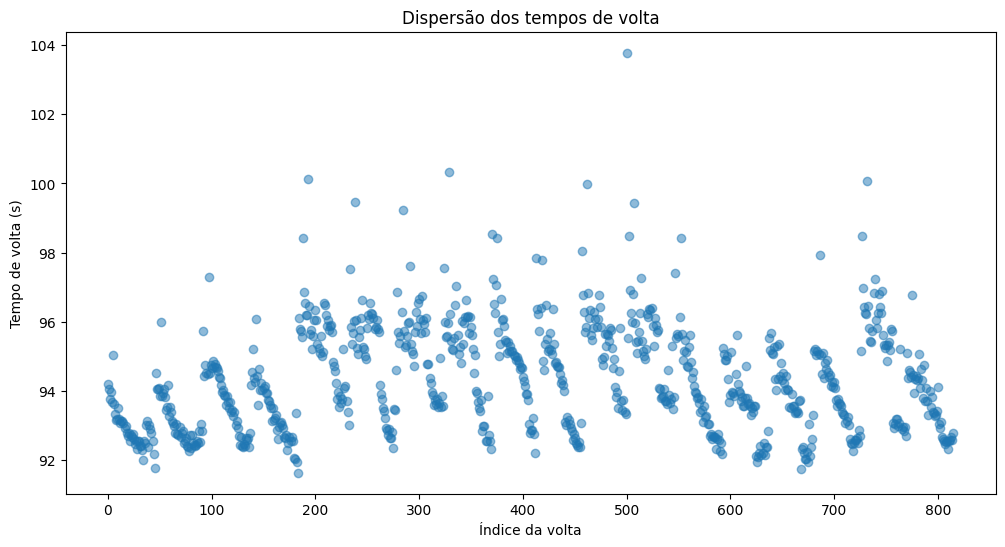

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


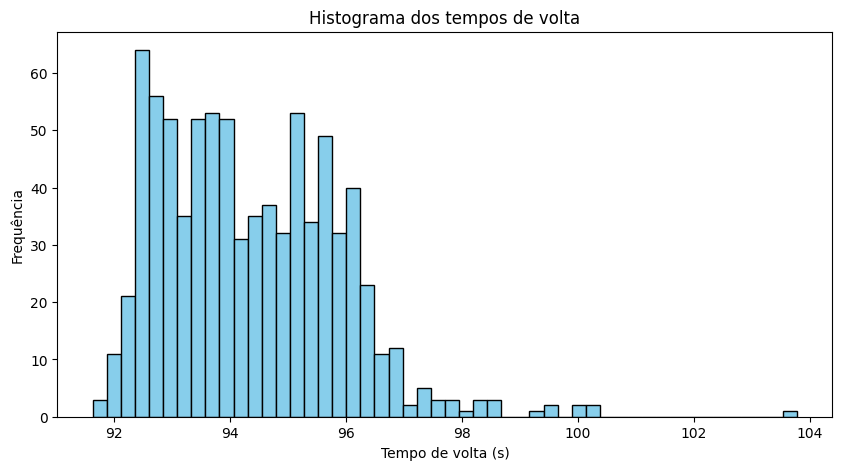

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


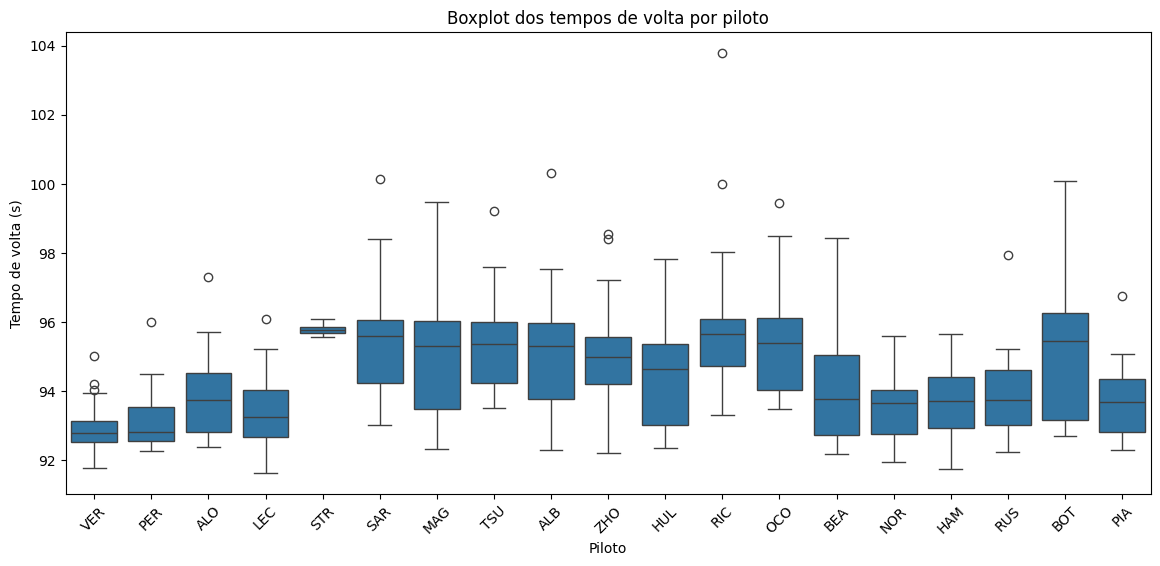

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
LEC   0 days 00:01:31.632000
HAM   0 days 00:01:31.746000
VER   0 days 00:01:31.773000
NOR   0 days 00:01:31.944000
BEA   0 days 00:01:32.186000
ZHO   0 days 00:01:32.208000
RUS   0 days 00:01:32.254000
PER   0 days 00:01:32.273000
ALB   0 days 00:01:32.307000
PIA   0 days 00:01:32.310000
MAG   0 days 00:01:32.338000
HUL   0 days 00:01:32.366000
ALO   0 days 00:01:32.387000
BOT   0 days 00:01:32.706000
SAR   0 days 00:01:33.026000
RIC   0 days 00:01:33.323000
OCO   0 days 00:01:33.481000
TSU   0 days 00:01:33.523000
STR   0 days 00:01:35.560000
Name: LapTime, dtype: timedelta64[ns]


In [ ]:
year = 2024
grand_prix = 'Arabia Saudita'
race_date = '2024-03-09'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [ ]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,46,95.021261,1.581656,92.307,100.318,95.3205,8.011,2024,Arabia Saudita,2024-03-09
1,ALO,46,93.769174,1.035202,92.387,97.296,93.7615,4.909,2024,Arabia Saudita,2024-03-09
2,BEA,46,94.031696,1.415408,92.186,98.427,93.7795,6.241,2024,Arabia Saudita,2024-03-09
3,BOT,43,95.271535,1.694499,92.706,100.082,95.4470,7.376,2024,Arabia Saudita,2024-03-09
4,HAM,44,93.712773,1.111503,91.746,95.672,93.7175,3.926,2024,Arabia Saudita,2024-03-09
5,HUL,44,94.426500,1.491661,92.366,97.836,94.6495,5.470,2024,Arabia Saudita,2024-03-09
6,LEC,46,93.377087,0.907154,91.632,96.082,93.2535,4.450,2024,Arabia Saudita,2024-03-09
7,MAG,46,94.965826,1.533279,92.338,99.463,95.3165,7.125,2024,Arabia Saudita,2024-03-09
8,NOR,44,93.607045,0.989678,91.944,95.607,93.6620,3.663,2024,Arabia Saudita,2024-03-09
9,OCO,45,95.334867,1.331935,93.481,99.439,95.4000,5.958,2024,Arabia Saudita,2024-03-09


In [ ]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [ ]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,46,95.021261,1.581656,92.307,100.318,95.3205,8.011,2024,Arabia Saudita,2024-03-09,50.0,True
1,ALO,46,93.769174,1.035202,92.387,97.296,93.7615,4.909,2024,Arabia Saudita,2024-03-09,50.0,True
2,BEA,46,94.031696,1.415408,92.186,98.427,93.7795,6.241,2024,Arabia Saudita,2024-03-09,50.0,True
3,BOT,43,95.271535,1.694499,92.706,100.082,95.4470,7.376,2024,Arabia Saudita,2024-03-09,49.0,True
4,HAM,44,93.712773,1.111503,91.746,95.672,93.7175,3.926,2024,Arabia Saudita,2024-03-09,50.0,True
5,HUL,44,94.426500,1.491661,92.366,97.836,94.6495,5.470,2024,Arabia Saudita,2024-03-09,50.0,True
6,LEC,46,93.377087,0.907154,91.632,96.082,93.2535,4.450,2024,Arabia Saudita,2024-03-09,50.0,True
7,MAG,46,94.965826,1.533279,92.338,99.463,95.3165,7.125,2024,Arabia Saudita,2024-03-09,50.0,True
8,NOR,44,93.607045,0.989678,91.944,95.607,93.6620,3.663,2024,Arabia Saudita,2024-03-09,50.0,True
9,OCO,45,95.334867,1.331935,93.481,99.439,95.4000,5.958,2024,Arabia Saudita,2024-03-09,49.0,True


In [ ]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,8.0,25.000000,0.000000,0.140000,0.860000
1,ALO,1,8.0,25.000000,0.000000,0.140000,0.860000
2,BEA,1,8.0,25.000000,0.140000,0.000000,0.860000
3,BOT,2,8.0,16.333333,0.428571,0.000000,0.571429
4,GAS,0,0.0,1.000000,0.000000,1.000000,0.000000
5,HAM,1,37.0,25.000000,0.280000,0.720000,0.000000
6,HUL,1,34.0,25.000000,0.000000,0.660000,0.340000
7,LEC,1,8.0,25.000000,0.000000,0.140000,0.860000
8,MAG,1,8.0,25.000000,0.000000,0.140000,0.860000
9,NOR,1,38.0,25.000000,0.260000,0.740000,0.000000


In [ ]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [ ]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,46,95.021261,1.581656,92.307,100.318,95.3205,8.011,2024,Arabia Saudita,2024-03-09,50.0,True,1,8.0,25.000000,0.000000,0.140000,0.860000
1,ALO,46,93.769174,1.035202,92.387,97.296,93.7615,4.909,2024,Arabia Saudita,2024-03-09,50.0,True,1,8.0,25.000000,0.000000,0.140000,0.860000
2,BEA,46,94.031696,1.415408,92.186,98.427,93.7795,6.241,2024,Arabia Saudita,2024-03-09,50.0,True,1,8.0,25.000000,0.140000,0.000000,0.860000
3,BOT,43,95.271535,1.694499,92.706,100.082,95.4470,7.376,2024,Arabia Saudita,2024-03-09,49.0,True,2,8.0,16.333333,0.428571,0.000000,0.571429
4,HAM,44,93.712773,1.111503,91.746,95.672,93.7175,3.926,2024,Arabia Saudita,2024-03-09,50.0,True,1,37.0,25.000000,0.280000,0.720000,0.000000
5,HUL,44,94.426500,1.491661,92.366,97.836,94.6495,5.470,2024,Arabia Saudita,2024-03-09,50.0,True,1,34.0,25.000000,0.000000,0.660000,0.340000
6,LEC,46,93.377087,0.907154,91.632,96.082,93.2535,4.450,2024,Arabia Saudita,2024-03-09,50.0,True,1,8.0,25.000000,0.000000,0.140000,0.860000
7,MAG,46,94.965826,1.533279,92.338,99.463,95.3165,7.125,2024,Arabia Saudita,2024-03-09,50.0,True,1,8.0,25.000000,0.000000,0.140000,0.860000
8,NOR,44,93.607045,0.989678,91.944,95.607,93.6620,3.663,2024,Arabia Saudita,2024-03-09,50.0,True,1,38.0,25.000000,0.260000,0.740000,0.000000
9,OCO,45,95.334867,1.331935,93.481,99.439,95.4000,5.958,2024,Arabia Saudita,2024-03-09,49.0,True,1,8.0,24.500000,0.000000,0.142857,0.857143


In [ ]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (19, 19)
Pilotos presentes: 19


In [ ]:
df_completo.to_csv('df_completoArabiaSaudita.csv', index=False)
